# Warehouse Storage Optimization

## 1. Storage Location Assignment

### Distance Matrix and Weights

#### Distance Matrix

In [ ]:
#%pip install pandas
#%pip install numpy
#%pip install scipy
#%pip install matplotlib

import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

  Using cached scipy-1.16.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.16.2-cp312-cp312-win_amd64.whl (38.6 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached matplotlib-3.10.6-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.0-cp312-cp312-win_amd64.whl.metadata (113 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.3.0-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.4-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.6-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.0-cp312-cp312-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp312-cp312-win_a

### Manhattan Distance
To calculate the distance matrix, we made use of the Manhatten Distance.
The distance between location $k$ at coordinates $(x_k, y_k)$ and location $j$ at coordinates $(x_j, y_j)$ is given by:

$$
d_{kj} = |x_k - x_j| + |y_k - y_j|
$$


In [2]:
# Define storage coordinates for 16 locations:
# Numbering: 1..4 across top row (y=4), 5..8 next (y=3), 9..12 (y=2), 13..16 (y=1)
coords = {}
for i in range(1,17):
    col = ((i-1) % 4) + 1
    row = 4 - ((i-1) // 4)
    coords[i] = (float(col), float(row))

# Define IO coordinates as reasoned:
io_coords = {
    'IO1': (2.5, 0.5),  # bottom center (equidistant from 14 and 15)
    'IO2': (0.5, 2.5),  # left middle (equidistant from 5 and 9)
    'IO3': (2.5, 4.5)   # top center (equidistant from 2 and 3)
}

# Compute Manhattan distance matrix (IO x storage)
dist_df = pd.DataFrame(index=io_coords.keys(), columns=[f"Loc{i}" for i in range(1,17)], dtype=float)
for io, iocoord in io_coords.items():
    for loc, sc in coords.items():
        dist = abs(iocoord[0] - sc[0]) + abs(iocoord[1] - sc[1])
        dist_df.loc[io, f"Loc{loc}"] = dist

# Show results
dist_df_display = dist_df.copy()
print(dist_df.T)

NameError: name 'pd' is not defined

### Weighted Cost Function
We computed the weight martix as followed:


The weighted cost of assigning item $i$ to location $j$ is defined as:

$$
w_{ij} = \frac{\sum_{k=1}^{3} c_{ik} f_{ik} d_{kj}}{S_i}
$$

where  

- $c_{ik}$ = is the cost of moving a unit load of item $i$ to/from I/O point $k$  
- $f_{ik}$ =  is the frequency of trips for item $i$ to/from I/O point $k$  
- $d_{kj}$ =  is the distance between I/O point $k$ and storage location$j$  
- $S_i$ = s the total number of storage spaces required for item $i$ 


In [ ]:
# Code to calculate weights matrix
# Given tables: frequencies (trips) for each item-IO and costs per unit load
freq = pd.DataFrame({
    'IO1':[150,60,96,175],
    'IO2':[25,200,15,135],
    'IO3':[88,150,85,90]
}, index=['A','B','C','D'])

unit_cost = pd.DataFrame({
    'IO1':[6,7,4,15],
    'IO2':[5,3,7,8],
    'IO3':[5,6,9,12]
}, index=['A','B','C','D'])

storage_spaces = pd.Series({
    'A':3, 'B':5, 'C':2, 'D':6
})

# Compute weight per item-location as sum over IO points of (frequency * unit_cost * distance)
items = ['A','B','C','D']
weight = pd.DataFrame(index=items, columns=[f"Loc{i}" for i in range(1,17)], dtype=float)
for item in items:
    s = storage_spaces.loc[item]
    for loc in range(1,17):
        total = 0.0
        for io in ['IO1','IO2','IO3']:
            f = freq.loc[item, io]
            c = unit_cost.loc[item, io]
            d = dist_df.loc[io, f"Loc{loc}"]
            total += (f * c * d)
        total /= s  # Normalize by storage spaces for the item
        weight.loc[item, f"Loc{loc}"] = total

weight_display = weight.copy()

print(weight.T)

                 A       B       C       D
Loc1   1876.666667  1020.0  1830.0  2907.5
Loc2   1471.666667   876.0  1308.0  2470.0
Loc3   1513.333333   996.0  1360.5  2650.0
Loc4   2001.666667  1380.0  1987.5  3447.5
Loc5   1681.666667   996.0  1968.0  2470.0
Loc6   1276.666667   852.0  1446.0  2032.5
Loc7   1318.333333   972.0  1498.5  2212.5
Loc8   1806.666667  1356.0  2125.5  3010.0
Loc9   1528.333333  1092.0  2158.5  2212.5
Loc10  1123.333333   948.0  1636.5  1775.0
Loc11  1165.000000  1068.0  1689.0  1955.0
Loc12  1653.333333  1452.0  2316.0  2752.5
Loc13  1416.666667  1308.0  2401.5  2135.0
Loc14  1011.666667  1164.0  1879.5  1697.5
Loc15  1053.333333  1284.0  1932.0  1877.5
Loc16  1541.666667  1668.0  2559.0  2675.0


### Mathematical Model (SLAP)

#### Sets
- $I = \{1, 2, \dots, n\}$ : set of items.  
- $J = \{1, 2, \dots, m\}$ : set of available storage locations.  

Here, $n = m = 16$.

#### Parameters
- $c_{ij}$ : cost of assigning item $i \in I$ to location $j \in J$.  
The costs are based on the weight martix determined above

#### Decision Variables
$$
x_{ij} =
\begin{cases}
1 & \text{if item $i$ is assigned to location $j$} \\
0 & \text{@}
\end{cases}
$$

#### Objective
$$
\min \sum_{i \in I} \sum_{j \in J} c_{ij} x_{ij}
$$

#### Constraints

1. **Each item must be assigned to exactly one location**
$$
\sum_{j \in J} x_{ij} = 1 \quad \forall i \in I
$$

2. **Each location must receive exactly one item**
$$
\sum_{i \in I} x_{ij} = 1 \quad \forall j \in J
$$

3. **Binary constraint**
$$
x_{ij} \in \{0,1\} \quad \forall i \in I, j \in J
$$


In [16]:
# MIP leading to optimal product-location assignment

assignment = {}
obj_value = None
req = storage_spaces.to_dict()
color_map = {"A": "blue", "B": "green", "C": "orange", "D": "red"}

expanded_items = []
for item in items:
    for k in range(req[item]):
        expanded_items.append(item)
        
# cost matrix: rows=expanded_items (16), cols=locations(16)
cost_mat = np.zeros((16,16))
for i,item in enumerate(expanded_items):
    for j in range(16):
        cost_mat[i,j] = weight.loc[item, f"Loc{j+1}"]
row_ind, col_ind = linear_sum_assignment(cost_mat)
obj_value = cost_mat[row_ind, col_ind].sum()
assignment = {}
for r,c in zip(row_ind, col_ind):
    assignment[c+1] = expanded_items[r]


# Build assignment dataframe
assign_df = pd.DataFrame({
    'Location': [f"Loc{loc}" for loc in range(1,17)],
    'Coord_x': [coords[loc][0] for loc in range(1,17)],
    'Coord_y': [coords[loc][1] for loc in range(1,17)],
    'Assigned_Item': [assignment[loc] for loc in range(1,17)],
    'Weight': [weight.loc[assignment[loc], f"Loc{loc}"] for loc in range(1,17)]
})

print(f"Objective value (total travel cost): {obj_value:.2f}\n")
print(assign_df.to_string(index=False))

# Plot assignment
fig, ax = plt.subplots(figsize=(6,6))
for loc in range(1,17):
    x0, y0 = coords[loc] # center of square
    rect = plt.Rectangle((x0-0.5, y0-0.5), 1, 1, fill=False, linewidth=1) # square of size 1x1
    ax.add_patch(rect) # add square to plot
for io, c in io_coords.items(): # plot IO points
    ax.scatter(c[0], c[1], s=150, edgecolors='black', marker='o', color='gray') # IO point
    ax.text(c[0], c[1]+0.15, io, ha='center', va='bottom') # IO label
for loc in range(1,17):
    x0, y0 = coords[loc] # center of square
    item = assignment[loc]  # assigned item
    ax.scatter(x0, y0, s=500, marker='o', color=color_map[item])
    ax.text(x0, y0, f"{loc}\n{item}", ha='center', va='center', color='white', fontsize=8, fontweight='bold') # label
ax.set_xlim(0,5); ax.set_ylim(0,5)
ax.set_xticks([]); ax.set_yticks([])
ax.set_title(f"Product-location assignment (Cost = {obj_value:.2f})")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


NameError: name 'storage_spaces' is not defined

Example optimal assignment (illustrative only):

```
Min. travel cost: 42,420
 ╔═════════════ I/O ═════╦═══════╗
 ║   A       A       A   ║   B   ║
 ╠═══════════════╦═══════╣       ║
 ║   D       D   ║   C   ║   B   ║
I/O              ║       ║       ║
 ║   D       D   ║   C   ║   B   ║
 ║               ╠═══════╝       ║
 ║   D       D   ║   B       B   ║
 ╚═════════════ I/O ═════════════╝
```

### 2. Random vs. Dedicated Policies

The answer comprises:

- Total storage for dedicated policy.
- Total storage for random policy.
- Reasoning behind the totals.

### Notation
Let $d_{i,t}$ be demand of item $i$ in period $t$ for $i=1,\dots,n$ and $t=1,\dots,T$.

### Safety stock (10% of next period demand, rounded up)
$$
SS_{i,t} \;=\; \left\lceil 0.10 \cdot d_{i,t+1} \right\rceil 
\qquad \forall t \in T.,
$$
where we take $d_{i,T+1}=0$ (or treat it as not available) so 
$SS_{i,T}=\lceil 0\rceil = 0$ if no next period exists.

### Inventory
We calculate the inventory by adding the demand and the safety stock:
$$
I_{i,t} \;=\; d_{i,t} + SS_{i,t} \qquad \forall t \in T \;\land\; \forall i \in I.
$$

### Dedicated total storage
For each item $i$ take its maximum inventory across periods, we then caculate the dedicated total $ Z_{dedicated} $ by summing then:
$$
Z_{dedicated} \;=\; \sum_{i=1}^{n} \max_{t} I_{i,t} \qquad \forall t \in T.
$$

### Random capacity 
First we calculate the pooled inventory for every period:
$$
P_t \;=\; \sum_{i=1}^{n} I_{i,t}.
$$
Then the random capacity $ Z_{random} $ required is the maximum of the pooled inventory over all periods:
$$
Z_{random} \;=\; \max_{t} P_t \;=\; \max_{t} \sum_{i=1}^{n} I_{i,t} \qquad \forall t \in T.
$$

## Results

We find that the dedicated total storage spaces required is 369 and that the random total storage spaces required is 252. As can be concluded from the graph as shown below the random space requires meets up with the demand line. while the dedicated total stoage space is quite a bit higher. If the demand never increases above this level the random space requirement sould be sufficient but assuming this is tricky since it can create easily OOS if the demand increases unexpectly. However with the dedicated policy it never comes close so you will waste quite a lot of space which is not ideal as well.

Shifted Demand (for Safety Stock Calculation):
            A     B     C     D     E
Period                              
1       15.0   8.0  15.0  22.0  12.0
2       30.0   4.0  16.0  25.0  88.0
3       12.0   6.0  17.0  21.0  66.0
4       14.0   7.0  18.0  18.0  79.0
5       60.0   1.0  19.0  14.0  55.0
6       17.0  12.0  15.0  23.0   9.0
7       20.0  40.0  16.0  36.0  25.0
8       21.0  13.0  17.0  30.0  96.0
9       22.0  12.0  18.0  22.0  90.0
10      23.0  12.0  19.0  89.0  90.0
11      23.0  12.0  15.0  22.0  88.0
12       NaN   NaN   NaN   NaN   NaN
Safety Stock:
           A    B    C    D     E
Period                          
1       2.0  1.0  2.0  3.0   2.0
2       3.0  1.0  2.0  3.0   9.0
3       2.0  1.0  2.0  3.0   7.0
4       2.0  1.0  2.0  2.0   8.0
5       6.0  1.0  2.0  2.0   6.0
6       2.0  2.0  2.0  3.0   1.0
7       2.0  4.0  2.0  4.0   3.0
8       3.0  2.0  2.0  3.0  10.0
9       3.0  2.0  2.0  3.0   9.0
10      3.0  2.0  2.0  9.0   9.0
11      3.0  2.0  2.0  

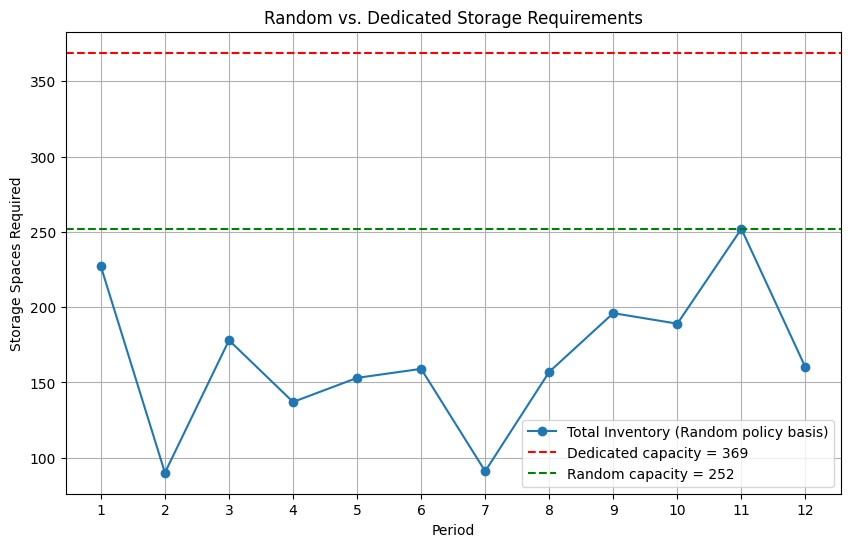

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Input data ---
data = {
    "A": [20,15,30,12,14,60,17,20,21,22,23,23],
    "B": [12,8,4,6,7,1,12,40,13,12,12,12],
    "C": [66,15,16,17,18,19,15,16,17,18,19,15],
    "D": [22,22,25,21,18,14,23,36,30,22,89,22],
    "E": [97,12,88,66,79,55,9,25,96,90,90,88]
}
df = pd.DataFrame(data, index=range(1,13))
df.index.name = "Period"

# --- Safety stock (10% of next period, rounded up) ---
safety_stock = df.shift(-1) * 0.10
print("Shifted Demand (for Safety Stock Calculation):\n", df.shift(-1))
safety_stock = np.ceil(safety_stock.fillna(0))
print("Safety Stock:\n", safety_stock)

# --- Inventory = receipt + safety stock ---
inventory = df + safety_stock
print("Inventory:\n", inventory)

# --- Dedicated and random totals ---
dedicated_total = inventory.max().sum()
print(f"Dedicated total storage spaces required: {dedicated_total}")
# step for checking 
random_summary = inventory.sum(axis=1)
print("Random summary (sum across items per period):\n", random_summary)
random_total = inventory.sum(axis=1).max()
print(f"Random total storage spaces required: {random_total}")

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(inventory.sum(axis=1), marker='o', label="Total Inventory (Random policy basis)")
plt.axhline(dedicated_total, color='red', linestyle='--', label=f"Dedicated capacity = {int(dedicated_total)}")
plt.axhline(random_total, color='green', linestyle='--', label=f"Random capacity = {int(random_total)}")

plt.title("Random vs. Dedicated Storage Requirements")
plt.xlabel("Period")
plt.ylabel("Storage Spaces Required")
plt.xticks(range(1,13))
plt.legend()
plt.grid(True)
plt.show()
